In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.optimize import minimize

#import numpy as np
import autograd.numpy as np
import autograd.numpy.random as npr
from autograd import grad

# flatten_func is moved to autograd.misc.flatten in v1.2, see
# https://github.com/HIPS/autograd/blob/master/autograd/misc/flatten.py
from autograd.misc.flatten import flatten_func, flatten

## Generate data

In [2]:
def f1(x):
    return x**2/20 + np.sin(2*x)

((201, 1), (201, 1))

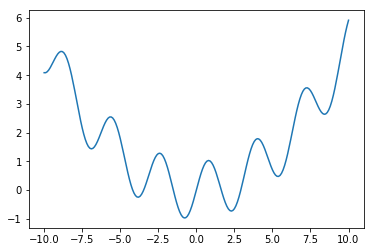

In [3]:
x = np.arange(-10, 10+1e-8, 0.1).reshape(-1,1) # shape: [n_sample*n_in] (n_in=1 here)
y_true = f1(x)
plt.plot(x, y_true) 
x.shape, y_true.shape

## Build NN

https://github.com/HIPS/autograd/blob/master/examples/neural_net_regression.py

In [4]:
def init_weights(n_in=1, n_hidden=10, n_out=1):
    W1 = npr.randn(n_in, n_hidden)
    b1 = np.zeros(n_hidden)
    W2 = npr.randn(n_hidden, n_out)
    b2 = np.zeros(n_out)
    params = [W1, b1, W2, b2]
    return params

params = init_weights()
print([ p.shape for p in params ])

[(1, 10), (10,), (10, 1), (1,)]


In [5]:
def predict(params, x, act=np.tanh):
    W1, b1, W2, b2 = params
    
    a = act(np.dot(x, W1) + b1)
    y = np.dot(a, W2) + b2
    
    return y

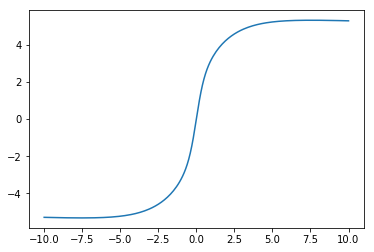

In [6]:
y_pred = predict(params, x)
plt.plot(x, y_pred)

In [7]:
def loss_func(params, x, y_true):
    y_pred = predict(params, x)
    loss = np.mean((y_pred - y_true)**2)
    return loss

In [8]:
loss_func(params, x, y_true)

28.898865816636931

In [9]:
loss_grad_func = grad(loss_func)

In [10]:
loss_grad_func(params, x, y_true)

[array([[  8.05876129e+00,   6.45502348e-01,   1.03047411e-02,
          -8.47532068e-03,   8.98434943e+01,   2.00837795e-01,
           1.20211644e-01,   2.41467728e+01,  -8.39200998e+00,
          -3.96956008e-02]]),
 array([ -2.77735020e-01,  -1.48356874e-02,  -2.00764167e-04,
          1.72777012e-04,  -5.78421450e+00,  -4.20996067e-03,
         -2.57959456e-03,  -1.55779365e+00,   3.65839206e-01,
          7.76864326e-04]),
 array([[ 8.28741195],
        [ 9.02679186],
        [ 9.29932157],
        [-9.24313745],
        [-0.80030449],
        [ 9.18414777],
        [-9.14001237],
        [-0.09054282],
        [-7.52922316],
        [-9.29643473]]),
 array([-3.36666667])]

## Gradient descend

In [11]:
lr = 0.01 # learning rate

params = init_weights(n_hidden = 20) # re-initialize weight
for t in range(1000):
    loss_grad =  loss_grad_func(params, x, y_true)
    
    for p, p_grad in zip(params, loss_grad):
        p -= lr*p_grad
        
    if t % 50 == 0:
        loss = loss_func(params, x, y_true)
        print('{:.3f}'.format(loss))

11.399
2.167
1.511
1.165
1.002
0.905
0.837
0.786
1.007
0.931
0.860
0.821
0.796
0.777
0.761
0.748
0.735
0.724
0.713
0.703


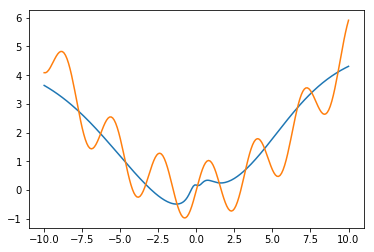

In [12]:
y_pred = predict(params, x)
plt.plot(x, y_pred)
plt.plot(x, y_true)

## Scipy optimization

Gradient function generated by autograd can be used the jacobian for scipy optimizers. Example:
- https://github.com/HIPS/autograd/blob/master/examples/rosenbrock.py

Scipy optimizer expects a single 1D array. Autograd provides functions to unroll a list of arrays to 1D array
- https://github.com/HIPS/autograd/blob/master/autograd/util.py#L87

### Flat weight parameters

In [13]:
params = init_weights(n_hidden = 10) # re-initialize weight

In [14]:
flattened_params, unflat_func = flatten(params)

In [15]:
def loss_wrap(flattened_params, x, y_true):
    params = unflat_func(flattened_params) # recover
    y_pred = predict(params, x)
    loss = np.mean((y_pred - y_true)**2)
    return loss

In [16]:
loss_func(params, x, y_true)

10.569623115001058

In [17]:
loss_wrap(flattened_params, x, y_true)

10.569623115001058

In [18]:
grad_wrap = grad(loss_wrap)

In [19]:
# use global x and y for now!
def loss_part(flattened_params):
    return loss_wrap(flattened_params, x, y_true)

def grad_part(flattened_params):
    # use global x and y for now
    return grad_wrap(flattened_params, x, y_true)

After v1.2, providing `jac` is faster.

In [20]:
%%time
optim_params = minimize(loss_part, flattened_params, method="BFGS",
                        jac = grad_part,
                        options = {'disp': True, 'maxiter':500} )

         Current function value: 0.010513
         Iterations: 500
         Function evaluations: 535
         Gradient evaluations: 535
CPU times: user 911 ms, sys: 12.5 ms, total: 923 ms
Wall time: 937 ms


In [21]:
o = optim_params
print(o.nit, o.njev, o.nfev, o.message)

500 535 535 Maximum number of iterations has been exceeded.


In [22]:
loss_wrap(optim_params.x , x, y_true)

0.010512592007940375

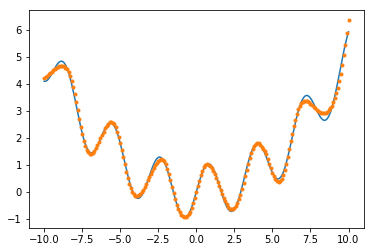

In [23]:
y_pred = predict(unflat_func(optim_params.x), x)
plt.plot(x, y_true)
plt.plot(x, y_pred, '.')